In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls "/content/drive/My Drive/Project"

DA_PatchingCombined.bak.ipynb	DenoisingAutoencoder.ipynb  Patching.py
DA_PatchingCombined.ipynb	input			    Untitled0.ipynb
DenoisingAutoencoder.bak.ipynb	Patching.ipynb


In [3]:
import keras
from keras.datasets import mnist
import numpy as np
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, InputLayer, Input
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


In [0]:
def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm
    
# KL Divergence regularizer for hidden unit activations
kullback_leibler_divergence = keras.losses.kullback_leibler_divergence
K = keras.backend

def kl_divergence_regularizer(activations):
    rho_hat = K.mean(activations, axis=0)
    nprho = np.full((rho_hat.get_shape().as_list()[0],) ,0.05)
    rho = tf.convert_to_tensor(nprho, dtype=tf.float32)
    return 0.01 * (kullback_leibler_divergence(rho, rho_hat)
                 + kullback_leibler_divergence(1 - rho, 1 - rho_hat))
    

def reconstruct_from_patches(patches, image_size, stride):
    img = np.zeros(image_size)
    i_h, i_w = img.shape

    p_h, p_w = patches.shape[1], patches.shape[2]

    patch_idx = 0
    for i in range(0, i_h, stride):
        for j in range(0, i_w, stride):
            if j + p_w > i_w or i + p_h > i_h:
                continue
            img[i:i + p_h, j:j + p_w] = patches[patch_idx]
            patch_idx += 1

    return img


In [0]:
def load_image(path, mode = 0):
    import cv2
    
    img = cv2.imread(path, mode)
    print("Original Image shape:", img.shape)
    return img

def downsample(img):
    # Convert from uint8 representation with values between 0 and 255 to
    # a floating point representation with values between 0 and 1.
    img = img / 255.
    
    # original_img = img.copy()

    # downsample for higher speed
    img = img[::4, ::4] + img[1::4, ::4] + img[::4, 1::4] + img[1::4, 1::4]
    print("Image shape after downsampling", img.shape)
    img /= 4.0
    return img


def patchify(img, patch_shape, stride=1):
    from sklearn.feature_extraction.image import extract_patches
    patches = extract_patches(img, patch_shape=patch_shape, extraction_step=stride)
    patches = patches.reshape(patches.shape[0] * patches.shape[1], 
                              patches.shape[2], patches.shape[3])
    return patches    


# TODO: vectorize patchify https://stackoverflow.com/a/48709806
def patchify_v(images, shape, stride=1):
    import numpy as np
    # By default it creats numpy array of dtype=float64 which will lead to Memory Error
    # float32 is a temporary solution and works sometimes
    # FIXME: find a way to prevent memory error
    res=np.array([patchify(img, shape, stride) for img in images], dtype="float32")
    return res


def depatchify(patches, img_shape, stride=1):
    reconstructed_img = reconstruct_from_patches(patches, img_shape, stride)
    return reconstructed_img


def depatchify_v(patches, shape, stride=1):
    import numpy as np
    
    res = []
    for img_patches in patches:
        res.append(depatchify(img_patches, shape, stride))
    return np.array(res)


def plot_patches(patches):
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(30, 30))
    for i, patch in enumerate(patches[:100]):
        plt.subplot(10, 10, i + 1)
        plt.imshow(patch, cmap=plt.cm.gray,
                   interpolation='nearest')
    
    
def plot_side_by_side(img1, img2):
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)

    plt.imshow(img1, vmin=0, vmax=1, cmap=plt.cm.gray,
               interpolation='nearest')


    plt.subplot(1, 2, 2)

    plt.imshow(img2, vmin=0, vmax=1, cmap=plt.cm.gray,
               interpolation='nearest')

    plt.show()

def load_data(train_path, test_path):
    import glob
    import numpy as np
    filelist_train = glob.glob(train_path)
    filelist_test = glob.glob(test_path)

    import cv2
    x_train = np.array([np.array(cv2.imread(fname, 0)) for fname in filelist_train[:30]])
    x_test = np.array([np.array(cv2.imread(fname, 0)) for fname in filelist_test])
    return x_train, x_test


def downsample_3d(img):
    # Convert from uint8 representation with values between 0 and 255 to
    # a floating point representation with values between 0 and 1.
    img = img / 255.
    
    # original_img = img.copy()

    # downsample for higher speed
    img = img[:,::4, ::4] + img[:,1::4, ::4] + img[:,::4, 1::4] + img[:,1::4, 1::4]
    print("Image shape after downsampling", img.shape)
    img /= 4.0
    return img

def join_patches(patches, num_images, p, ph, pw, h, w, stride):
    pred_patches = patches.reshape(num_images, p, ph, pw)
    pred_images = depatchify_v(pred_patches, (h, w), stride)
    return pred_images


In [6]:
# A dataset of 62 training and 4 test images of 512x512 dimension
# x_train, x_test = load_data("../input/imageinpainting/images/images/train/*",
#                             "../input/imageinpainting/images/images/test/*")
x_train, x_test = load_data("/content/drive/My Drive/Project/input/train/*",
                            "/content/drive/My Drive/Project/input/test/*")
print("x_train.shape", x_train.shape, " x_test.shape", x_test.shape)

x_train = downsample_3d(x_train)
x_test = downsample_3d(x_test)

n, h, w = x_train.shape # n = #of image samples
c = 1   # num channels in input images
print("n x h x w:", n, h, w)

x_train.shape (30, 256, 256)  x_test.shape (10, 256, 256)
Image shape after downsampling (30, 64, 64)
Image shape after downsampling (10, 64, 64)
n x h x w: 30 64 64


In [7]:
# normalize to range [0, 1]
# x_train = x_train.astype('float32') / 255.0
# x_test = x_test.astype('float32') / 255.0

# Reshape to include channel in dimension
# TODO: change channel to 3 when using RGB images
x_train = np.reshape(x_train, (len(x_train), h, w))  # by default uses `channels_last` image data format
x_test = np.reshape(x_test, (len(x_test), h, w))

# Dimensions after including channel info
x_train.shape, x_test.shape

((30, 64, 64), (10, 64, 64))

In [0]:
# def add_noise(data, noise_factor = 0.5):
#     # add noise
#     res = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape) 

#     # clip to range
#     res = np.clip(res, 0., 1.)
#     return res

def add_noise(image):
    _, row, col= image.shape
    mean = 0
    sigma = 0.1
    gauss = np.random.normal(mean, sigma, (row, col))
    gauss = gauss.reshape(row, col)
    noisy = image + gauss
    return noisy


x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

In [9]:
# choosing patch size of 64x64 we are able to recreate original image
# larger patch size gives poor reconstructed image quality
# smaller patch size gives out of memory error
patch_dim = (32, 32)
print("patch_dim (ph x pw):", patch_dim)

stride = 8

x_train_patches = patchify_v(x_train, patch_dim, stride)
x_train_noisy_patches = patchify_v(x_train_noisy, patch_dim, stride)
x_test_patches = patchify_v(x_test, patch_dim, stride)
x_test_noisy_patches = patchify_v(x_test_noisy, patch_dim, stride)

# shape of patches is: 
# num_images(n) x n_patches_per_img(p) x patch height(ph) x patch width(pw)
print("x_train_patches.shape", x_train_patches.shape)
_, p, ph, pw = x_train_patches.shape 
print("x_train patches.shape", x_train_patches.shape) 
print("x_train_noisy patches.shape", x_train_noisy_patches.shape) 
print("x_test_noisy patches.shape", x_test_noisy_patches.shape) 

# reconstructed_images = depatchify_v(x_train_patches, (h, w))
# print("reconstructed_images.shape", reconstructed_images.shape)
# plot_patches(x_train_patches[0])
# plot_side_by_side(x_train[0].reshape(h, w), reconstructed_images[0].reshape(h, w))

patch_dim (ph x pw): (32, 32)
x_train_patches.shape (30, 25, 32, 32)
x_train patches.shape (30, 25, 32, 32)
x_train_noisy patches.shape (30, 25, 32, 32)
x_test_noisy patches.shape (10, 25, 32, 32)


In [10]:
# reshape(flatten) so that we can pass to neural network
x_train_patches = x_train_patches.reshape(np.prod(x_train_patches.shape[:2]),
                                            np.prod(x_train_patches.shape[2:]))
x_train_noisy_patches = x_train_noisy_patches.reshape(np.prod(x_train_noisy_patches.shape[:2]),
                                                      np.prod(x_train_noisy_patches.shape[2:]))

x_test_noisy_patches = x_test_noisy_patches.reshape(np.prod(x_test_noisy_patches.shape[:2]),
                                                      np.prod(x_test_noisy_patches.shape[2:]))

# shape after flattening
x_train_patches.shape, x_train_noisy_patches.shape, x_test_noisy_patches.shape

((750, 1024), (750, 1024), (250, 1024))

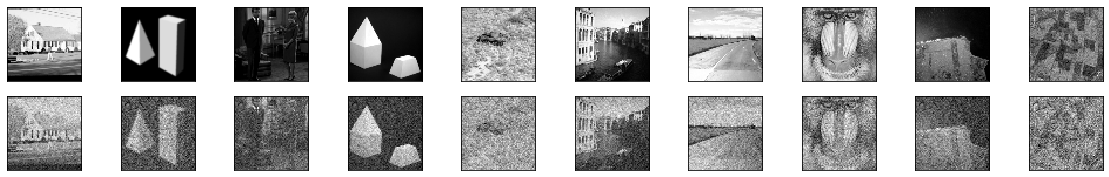

In [11]:
x_train_images = join_patches(x_train_patches, len(x_train), p, ph, pw, h, w, stride)
x_train_noisy_images = join_patches(x_train_noisy_patches, len(x_train), p, ph, pw, h, w, stride)

# print first 10 images
n = 10
plt.figure(figsize=(20, 3))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_train_images[i].reshape(h, w))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+10)
    plt.imshow(x_train_noisy_images[i].reshape(h, w))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [12]:
lambdaa = 0.0001
num_input_neurons = x_train_noisy_patches.shape[1]

input_layer = Input(shape=(num_input_neurons,))
hidden_layer = Dense(units=5*num_input_neurons, activation='sigmoid', 
                    activity_regularizer=kl_divergence_regularizer,
                    # kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(input_layer)
output_layer = Dense(units=num_input_neurons, activation='sigmoid',
                    # kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(hidden_layer)
da1 = Model(input_layer, output_layer)
da1.summary()





Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5120)              5248000   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              5243904   
Total params: 10,491,904
Trainable params: 10,491,904
Non-trainable params: 0
_________________________________________________________________


In [13]:
adam = keras.optimizers.Adam(lr=0.0005)
da1.compile(optimizer=adam, loss='mse')
da1.fit(x_train_noisy_patches, x_train_patches,
                epochs=100,
                batch_size=120,
                shuffle=True)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/100
750/750 [==============================] - 2s 2ms/step - loss: 14.8075
Epoch 2/100
750/750 [==============================] - 0s 116us/step - loss: 1.9649
Epoch 3/100
750/750 [==============================] - 0s 116us/step - loss: 0.1970
Epoch 4/100
750/750 [==============================] - 0s 105us/step - loss: 0.0777
Epoch 5/100
750/750 [==============================] - 0s 109us/step - loss: 0.1713
Epoch 6/100
750/750 [==============================] - 0s 107us/step - loss: 0.1925
Epoch 7/100
750/750 [==============================] - 0s 105us/step - loss: 0.1625
Epoch 8/100
750/750 [==============================] - 0s 104us/step - loss: 0.1411
Epoch 9/100
750/750 [==============================] - 0s 114us/step - loss: 0.1461
Epoch 10/100
750/750 [==============================] - 0s 104us/step - loss: 0.1054
Epoch 11/100
750/750 [==============================] - 0s 103us

In [14]:
# predicted = da1.predict(x_train_noisy_patches)
predicted = da1.predict(x_test_noisy_patches)
print(predicted.shape)

(250, 1024)


In [15]:
pred_images = join_patches(predicted, len(x_test), p, ph, pw, h, w, stride)
x_test_images = join_patches(x_test_patches, len(x_test), p, ph, pw, h, w, stride)
x_test_noisy_images = join_patches(x_test_noisy_patches, len(x_test), p, ph, pw, h, w, stride)

# pred_images = join_patches(predicted, len(x_train), p, ph, pw, h, w, stride)
# x_test_images = join_patches(x_train_patches, len(x_train), p, ph, pw, h, w, stride)
# x_test_noisy_images = join_patches(x_train_noisy_patches, len(x_train), p, ph, pw, h, w, stride)

print(pred_images.shape, x_test_images.shape, x_test_noisy_images.shape, stride)

(10, 64, 64) (10, 64, 64) (10, 64, 64) 8


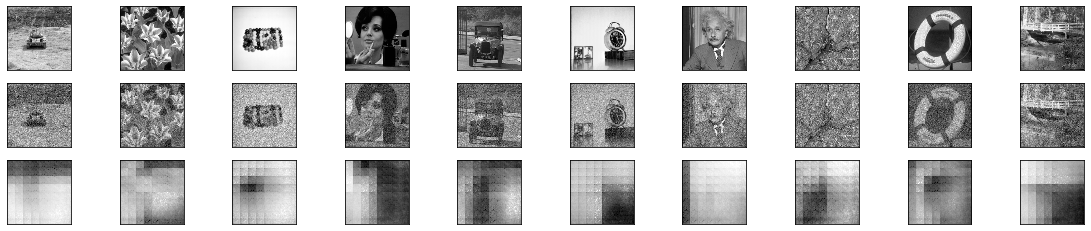

In [16]:
plt.figure(figsize=(40, 4))
for i in range(10):
    # display original images
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test_images[i].reshape(h, w))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display noisy images
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(x_test_noisy_images[i].reshape(h, w))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstructed images
    ax = plt.subplot(3, 20, 2 * 20 + i + 1)
    plt.imshow(pred_images[i].reshape(h, w))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.show()

In [0]:
import pandas as pd

hiddenLayerWeights = pd.DataFrame(da1.layers[1].get_weights()[0]).values
hiddenLayerBias = pd.DataFrame(da1.layers[1].get_weights()[1]).values
hiddenLayerWeights.shape, type(hiddenLayerWeights), hiddenLayerBias.shape, type(hiddenLayerBias)
Wx = np.dot(x_train_noisy_patches, hiddenLayerWeights)
b =  hiddenLayerBias.T
hX = sigmoid(Wx+b)

Wy = np.dot(x_train_patches, hiddenLayerWeights)
hY = sigmoid(Wy + b)

In [18]:
hX.shape, hY.shape

((750, 5120), (750, 5120))

In [19]:
# num_input_neurons = hX.shape[1]

input_layer2 = Input(shape=(5*num_input_neurons,))
hidden_layer2 = Dense(units=5*5*num_input_neurons, activation='sigmoid',
                    activity_regularizer=kl_divergence_regularizer,
                    # kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(input_layer2)
output_layer2 = Dense(units=5*num_input_neurons, activation='sigmoid',
                    # kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(hidden_layer2)
da2 = Model(input_layer2, output_layer2)
da2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5120)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 25600)             131097600 
_________________________________________________________________
dense_4 (Dense)              (None, 5120)              131077120 
Total params: 262,174,720
Trainable params: 262,174,720
Non-trainable params: 0
_________________________________________________________________


In [20]:
da2.compile(optimizer='adam', loss='mse')
da2.fit(hX, hY,
                epochs=50,
                batch_size=120,
                shuffle=True)

Epoch 1/50
750/750 [==============================] - 7s 10ms/step - loss: 77.4858
Epoch 2/50
750/750 [==============================] - 1s 2ms/step - loss: 26.1298
Epoch 3/50
750/750 [==============================] - 1s 2ms/step - loss: 13.9547
Epoch 4/50
750/750 [==============================] - 1s 2ms/step - loss: 9.3407
Epoch 5/50
750/750 [==============================] - 1s 2ms/step - loss: 7.4551
Epoch 6/50
750/750 [==============================] - 1s 2ms/step - loss: 6.0307
Epoch 7/50
750/750 [==============================] - 1s 2ms/step - loss: 5.1628
Epoch 8/50
750/750 [==============================] - 1s 2ms/step - loss: 4.6540
Epoch 9/50
750/750 [==============================] - 1s 2ms/step - loss: 4.1601
Epoch 10/50
750/750 [==============================] - 1s 2ms/step - loss: 3.7795
Epoch 11/50
750/750 [==============================] - 1s 2ms/step - loss: 3.3906
Epoch 12/50
750/750 [==============================] - 1s 2ms/step - loss: 3.0898
Epoch 13/50
750/750 [

In [0]:
# Extract weights
W1, B1 = da1.layers[1].get_weights()
W1_dash, B1_dash = da1.layers[2].get_weights()

W2, B2 = da2.layers[1].get_weights()
W2_dash, B2_dash = da2.layers[2].get_weights()


In [22]:
W1.shape, W2.shape, W2_dash.shape, W1_dash.shape
# B1.shape, B2.shape, B2_dash.shape, B1_dash.shape
# len(B1), len(B2), len(B2_dash), len(B1_dash)

((1024, 5120), (5120, 25600), (25600, 5120), (5120, 1024))

In [23]:
input_layer = Input(shape=(W1.shape[0],))
h1 = Dense(units=W1.shape[1], activation='sigmoid', 
                    # kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(input_layer)
h2 = Dense(units=W2.shape[1], activation='sigmoid', 
                    # kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(h1)
h3 = Dense(units=W2_dash.shape[1], activation='sigmoid', 
                    # kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(h2)
output_layer = Dense(units=W1_dash.shape[1], activation='sigmoid',
                    # kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(h3)

dnn = Model(input_layer, output_layer)

# Initialize with pretrained weights
B1 = np.random.uniform(0,1,B1.shape)
B2 = np.random.uniform(0,1,B2.shape)
B1_dash = np.random.uniform(0,1,B1_dash.shape)
B2_dash = np.random.uniform(0,1,B2_dash.shape)

dnn.layers[1].set_weights([W1, B1])
dnn.layers[2].set_weights([W2, B2])
dnn.layers[3].set_weights([W2_dash, B2_dash])
dnn.layers[4].set_weights([W1_dash, B1_dash])

dnn.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 5120)              5248000   
_________________________________________________________________
dense_6 (Dense)              (None, 25600)             131097600 
_________________________________________________________________
dense_7 (Dense)              (None, 5120)              131077120 
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              5243904   
Total params: 272,666,624
Trainable params: 272,666,624
Non-trainable params: 0
_________________________________________________________________


In [0]:
# x_sample = x_train[0].reshape(28, 28)
# plt.imshow(x_sample, interpolation='nearest')
# plt.show()

In [25]:
dnn.compile('adam', loss='mse')
dnn.fit(x_train_noisy_patches, x_train_patches,
                epochs=100,
                batch_size=120,
                shuffle=True)

Epoch 1/100
750/750 [==============================] - 7s 9ms/step - loss: 0.0885
Epoch 2/100
750/750 [==============================] - 2s 2ms/step - loss: 0.0546
Epoch 3/100
750/750 [==============================] - 2s 2ms/step - loss: 0.0558
Epoch 4/100
750/750 [==============================] - 2s 2ms/step - loss: 0.0550
Epoch 5/100
750/750 [==============================] - 2s 2ms/step - loss: 0.0540
Epoch 6/100
750/750 [==============================] - 2s 2ms/step - loss: 0.0528
Epoch 7/100
750/750 [==============================] - 2s 2ms/step - loss: 0.0516
Epoch 8/100
750/750 [==============================] - 2s 2ms/step - loss: 0.0502
Epoch 9/100
750/750 [==============================] - 2s 2ms/step - loss: 0.0482
Epoch 10/100
750/750 [==============================] - 2s 2ms/step - loss: 0.0465
Epoch 11/100
750/750 [==============================] - 2s 2ms/step - loss: 0.0441
Epoch 12/100
750/750 [==============================] - 2s 2ms/step - loss: 0.0413
Epoch 13/100


In [0]:
predicted2 = dnn.predict(x_test_noisy_patches)

In [0]:
pred_images2 = join_patches(predicted2, len(x_test), p, ph, pw, h, w, stride)

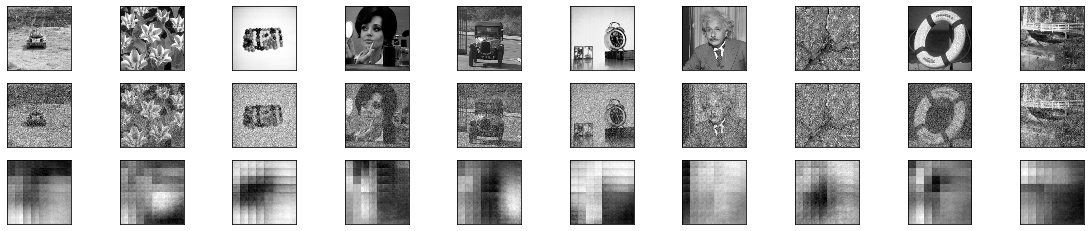

In [29]:
plt.figure(figsize=(40, 4))
for i in range(10):
    # display original images
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test[i].reshape(h, w))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display noisy images
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(x_test_noisy[i].reshape(h, w))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstructed images
    ax = plt.subplot(3, 20, 2 * 20 + i + 1)
    plt.imshow(pred_images2[i].reshape(h, w))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    
plt.show()

In [0]:
# from keras.datasets import mnist
# import numpy as np

# (x_train, _), (x_test, _) = mnist.load_data()

# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
# x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

# noise_factor = 0.5
# x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
# x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

# x_train_noisy = np.clip(x_train_noisy, 0., 1.)
# x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# n = 10
# plt.figure(figsize=(20, 2))
# for i in range(n):
#     ax = plt.subplot(1, n, i+1)
#     plt.imshow(x_test_noisy[i].reshape(28, 28))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
# plt.show()

In [0]:
# # rows = x_train_patches[:1089]
# # rows = rows.reshape(1089, 32, 32)
# # rows.shape
# x_train.shape
# r = depatchify(rows, (64, 64))
# r.shape, x_train[0].shape
# plot_side_by_side(r, x_train[0].reshape(h, w))

In [0]:
# # reshape(flatten) so that we can pass to neural network
# x_train = x_train.reshape(len(x_train), np.prod(x_train.shape[1:]))
# x_train_noisy = x_train_noisy.reshape(len(x_train_noisy), np.prod(x_train_noisy.shape[1:]))

# x_test = x_test.reshape(len(x_test), np.prod(x_test.shape[1:]))
# x_test_noisy = x_test_noisy.reshape(len(x_test_noisy), np.prod(x_test_noisy.shape[1:]))

# # shape after flattening
# x_train.shape, x_train_noisy.shape, x_test.shape, x_test_noisy.shape

In [0]:
    # import skimage
    # FIXME: removing channel dim here is ugly
    # img = img.reshape(img.shape[:-1]) 
    # patches = skimage.util.view_as_windows(img, shape, stride) 
    # patches = patches.reshape(patches.shape[0] * patches.shape[1],
    #                           patches.shape[2], patches.shape[3])
